In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
plt.ioff()
plt.style.use('ggplot')
import json
import os
import time
from IPython import display

import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Import data

In [3]:
with open('../data/tracks_fourier.json') as f:
    data = json.load(f)

In [123]:
DESCRIPTORS_ORDER = 2**8
SMOOTHING_ORDER = 2**5

fourier_orders = []
for track in data.values():
    fourier_orders.append(len(track['fourier-descriptors']['real']))
assert(min(fourier_orders) == max(fourier_orders) == DESCRIPTORS_ORDER)

def truncate_descriptors(a):
    assert(SMOOTHING_ORDER<len(a))
    mid = len(a) // 2
    low  = mid - SMOOTHING_ORDER // 2
    high = mid + SMOOTHING_ORDER // 2
    return np.fft.fftshift(a)[low:high]

def pad_descriptors(a):
    assert(DESCRIPTORS_ORDER>len(a))
    mid = DESCRIPTORS_ORDER // 2
    low  = mid - SMOOTHING_ORDER // 2
    high = mid + SMOOTHING_ORDER // 2
    a_padded = np.zeros(DESCRIPTORS_ORDER, np.complex_)
    a_padded[low:high] = a
    return np.fft.fftshift(a_padded)

### Data visualization

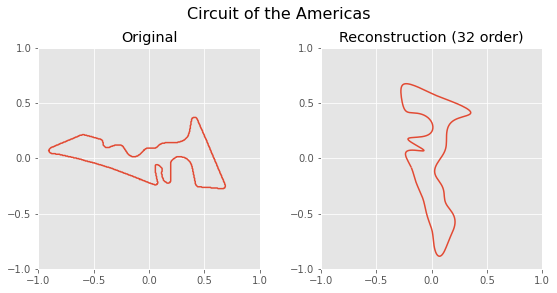

In [124]:
track_name_example = 'Circuit of the Americas'
track_data = data[track_name_example]

track_descp = np.array([ r + 1j * i for r,i in zip(track_data['fourier-descriptors']['real'], track_data['fourier-descriptors']['imag'])])
track_descp_trunc = truncate_descriptors(track_descp)
track_descp_padded = pad_descriptors(track_descp_trunc)
track_smoothed = np.fft.ifft(track_descp_padded)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
fig.suptitle(track_name_example, fontsize=16)
for ax in axs:
    ax.set_xlim(-1, 1)
    ax.set_xticks(np.linspace(-1., 1., 5))
    ax.set_ylim(-1, 1)
    ax.set_yticks(np.linspace(-1., 1., 5))
    ax.set_aspect('equal')
axs[0].plot(*np.array(track_data['points']).transpose())
axs[0].set_title('Original')
axs[1].plot(track_smoothed.real, track_smoothed.imag)
axs[1].set_title('Reconstruction ({} order)'.format(SMOOTHING_ORDER))

plt.tight_layout()
plt.show()
plt.close(fig)

In [125]:
path_save = '../data/tracks_smoothed{}_plots'.format(SMOOTHING_ORDER)

if not os.path.exists(path_save):
    os.makedirs(path_save)

    for name, track_data in data.items():
        track_descp = np.array([ r + 1j * i for r,i in zip(track_data['fourier-descriptors']['real'], track_data['fourier-descriptors']['imag'])])
        track_descp_trunc = truncate_descriptors(track_descp)
        track_descp_padded = pad_descriptors(track_descp_trunc)
        track_smoothed = np.fft.ifft(track_descp_padded)

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(track_smoothed.real, track_smoothed.imag)
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_title(name)
        ax.set_aspect('equal')
        fig.savefig(path_save+'/'+name.replace(' ', '_')+'.png', dpi=250)
        plt.close(fig)
else:
    print('Already generated')

Already generated


## Create dataset

In [126]:
data_training = []
for track in data.values():
    track_descp_complex = np.array([ r + 1j * i for r,i in zip(track['fourier-descriptors']['real'], track['fourier-descriptors']['imag'])])
    track_descp_trunc = truncate_descriptors(track_descp_complex)
    data_training.append(track_descp_trunc)
data_training = np.array(data_training)
print(data_training.shape, data_training.dtype)

(77, 32) complex128


### Data augmentation (rotation)

In [127]:
rotation_augmentation_factor = 8
train_dataset_augmented = [data_training * np.exp(1j * np.pi * i * 2 / rotation_augmentation_factor) for i in range(rotation_augmentation_factor)]
train_dataset_augmented = np.concatenate(train_dataset_augmented, axis=0)
print(train_dataset_augmented.shape, train_dataset_augmented.dtype)

(616, 32) complex128


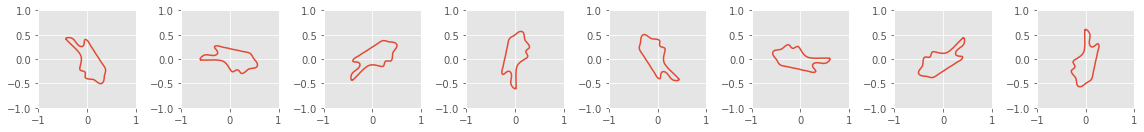

In [128]:
fig, axs = plt.subplots(1,rotation_augmentation_factor, figsize = (2*rotation_augmentation_factor, 3))

for ax, i in zip(axs,[i * data_training.shape[0] for i in range(rotation_augmentation_factor)]):
    track_descp_padded = pad_descriptors(train_dataset_augmented[i])
    track_smoothed = np.fft.ifft(track_descp_padded)
    ax.plot(track_smoothed.real, track_smoothed.imag)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()
plt.close(fig)

### Normalization

In [129]:
BUFFER_SIZE = train_dataset_augmented.shape[0]
BATCH_SIZE = 16
NORMALIZATION_FACTOR = 170.

# Use train_dataset_augmented_flat.view(np.complex64) to go back to complex representation, cannot process complex numbers with TF
train_dataset_augmented_flat = train_dataset_augmented.view(np.float64)
# Normalized
train_dataset_augmented_flat = train_dataset_augmented_flat / NORMALIZATION_FACTOR
# Add small noise
train_dataset_augmented_flat = train_dataset_augmented_flat + np.random.normal(0, .01, train_dataset_augmented_flat.shape)
print(train_dataset_augmented_flat.min(), train_dataset_augmented_flat.max())
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset_augmented_flat).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset_augmented_flat.shape

-0.9907718811503423 0.9698175127654604


(616, 64)

### Generator

In [144]:
from tensorflow.keras import layers

ENCODING_SIZE = 2**4

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32, use_bias=False, input_shape=(ENCODING_SIZE,)))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(64, use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(64, use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(128, use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(SMOOTHING_ORDER*2, use_bias=False, activation='tanh'))
    assert model.output_shape == (None, SMOOTHING_ORDER*2) # Note: None is the batch size, times 2 for flat representation, use output.view(np.complex64)

    return model

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 32)                512       
_________________________________________________________________
batch_normalization_24 (Batc (None, 32)                128       
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 64)                2048      
_________________________________________________________________
batch_normalization_25 (Batc (None, 64)                256       
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 64)              

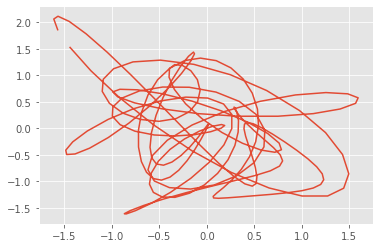

In [145]:
generator = make_generator_model()
generator.summary()

noise = tf.random.normal([1, ENCODING_SIZE])
generated_descp = generator([noise], training=False)

generated_track = np.fft.ifft(pad_descriptors(generated_descp.numpy().view(np.complex64)*NORMALIZATION_FACTOR))
plt.plot(generated_track.real, generated_track.imag)
plt.show()
plt.close(fig)

### Discriminator

In [146]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, input_shape=[SMOOTHING_ORDER*2]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(32))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1))

    return model

In [147]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_descp)
print(decision)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 32)              

### Loss & Optimizers

In [148]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [149]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [150]:
checkpoint_dir = '../data/training/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Define training

In [151]:
EPOCHS = 400
num_examples_to_generate = 3*3
CHECKPOINT_EPOCHS = 10

seed = tf.random.normal([num_examples_to_generate, ENCODING_SIZE])

In [152]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(descp):
    noise = tf.random.normal([BATCH_SIZE, ENCODING_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_descp = generator(noise, training=True)

        real_output = discriminator(descp, training=True)
        fake_output = discriminator(generated_descp, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return (gen_loss, disc_loss)

In [153]:
def train(dataset, epochs):
    hist = {'gen_loss':[], 'disc_loss': []}
    for epoch in range(epochs):
        start = time.time()
        gen_loss, disc_loss, batch_num = 0., 0., 0
        
        for descp_batch in dataset:
            gen_loss_tmp, disc_loss_tmp = train_step(descp_batch)
            gen_loss += gen_loss_tmp.numpy()
            disc_loss += disc_loss_tmp.numpy()
            batch_num += 1
        
        hist['gen_loss'].append(gen_loss / batch_num)
        hist['disc_loss'].append(disc_loss / batch_num)
        
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        if (epoch + 1) % CHECKPOINT_EPOCHS == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    generate_and_save_images(generator,
                           epochs,
                           seed)
    return hist

In [154]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    if (epoch + 1) % CHECKPOINT_EPOCHS == 0:
        display.clear_output(wait=True)
        predictions = model(test_input, training=False)
        predictions = predictions * NORMALIZATION_FACTOR
        fig = plt.figure(figsize=(6, 6))

        for i, generated_descp in enumerate(predictions):
            plt.subplot(3, 3, i+1)
            generated_track = np.fft.ifft(pad_descriptors(generated_descp.numpy().view(np.complex64)))
            plt.plot(generated_track.real, generated_track.imag)

        plt.savefig('../data/training/image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()

## Training

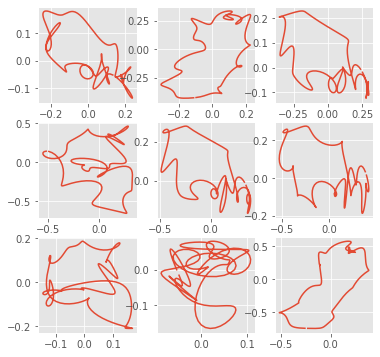

Time for epoch 399 is 0.6324424743652344 sec
Time for epoch 400 is 0.16098904609680176 sec


In [155]:
training_history = train(train_dataset, EPOCHS)

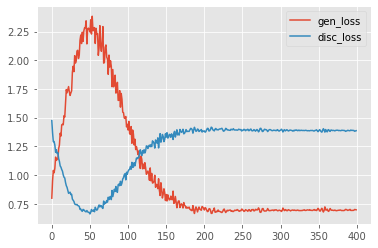

In [156]:
plt.plot(training_history['gen_loss'], label='gen_loss')
plt.plot(training_history['disc_loss'], label='disc_loss')
plt.legend()
#plt.yscale('log')
plt.show()

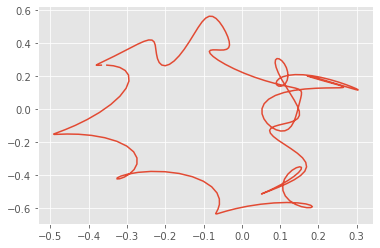

In [176]:
plt.clf()
generated_descp = generator(tf.random.normal([1,ENCODING_SIZE]), training=False)[0]
generated_descp = generated_descp * NORMALIZATION_FACTOR
generated_track = np.fft.ifft(pad_descriptors(generated_descp.numpy().view(np.complex64)))
plt.plot(generated_track.real, generated_track.imag)
plt.show()